# Installing the Dependencies

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!pip install -r requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 16517, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 16517 (delta 47), reused 50 (delta 16), pack-reused 16402
Receiving objects: 100% (16517/16517), 15.12 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (11309/11309), done.
/kaggle/working/yolov5
  Obtaining dependency information for thop>=0.1.1 from https://files.pythonhosted.org/packages/bb/0f/72beeab4ff5221dc47127c80f8834b4bcd0cb36f6ba91c0b1d04a1233403/thop-0.1.1.post2209072238-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics>=8.0.232 from https://files.pythonhosted.org/packages/ab/3b/4b9b3d590128bc76b056dee2a4bd932046f965164717217ce773bba50070/ultralytics-8.1.30-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 628.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.0/722.0 kB 5.1 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import matplotlib.image as mpimg
import os

# Reading the contents of coco128.yaml


In [3]:
# Reading the contents of coco128.yaml
yaml_path = '/kaggle/input/rider-with-helmet-without-helmet-number-plate/coco128.yaml'

with open(yaml_path, 'r') as file:
    yaml_contents = file.read()
    
print(yaml_contents)

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


# Count Class Instances

In [4]:
# Function to count class instances in a given folder
def count_class_instances(folder_path):
    labels_folder = Path(folder_path) / 'labels'
    class_counts = Counter()

    for label_file in labels_folder.glob('*.txt'):
        with open(label_file, 'r') as file:
            annotations = file.readlines()
            for annotation in annotations:
                class_id = int(annotation.split()[0])
                class_counts[class_id] += 1

    return class_counts

# Example usage
train_class_counts = count_class_instances('/kaggle/input/rider-with-helmet-without-helmet-number-plate/train')
val_class_counts = count_class_instances('/kaggle/input/rider-with-helmet-without-helmet-number-plate/val')

In [5]:
print("Train Counts: ",train_class_counts)
print("Validation Counts: ",val_class_counts)

Train Counts:  Counter({2: 120, 3: 116, 1: 93, 0: 64})
Validation Counts:  Counter({2: 23, 3: 22, 1: 15, 0: 13})


- Class 2: 120 instances
- Class 3: 116 instances
- Class 1: 93 instances
- Class 0: 64 instances

# Data Augmentation and Preprocessing

In [6]:
# Function for augmenting images (horizontal flip and brightness adjustment)
def augment_image(image):
    flipped = cv2.flip(image, 1)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, np.random.randint(30, 70))
    final_hsv = cv2.merge((h, s, v))
    bright_adjusted = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    return flipped, bright_adjusted

# Function to demonstrate augmentation on a sample image
def demonstrate_augmentation(folder_path, class_id=0):
    labels_folder = Path(folder_path) / 'labels'
    images_folder = Path(folder_path) / 'images'

    for label_file in labels_folder.glob('*.txt'):
        with open(label_file, 'r') as file:
            annotations = file.readlines()
            if any(int(ann.split()[0]) == class_id for ann in annotations):
                image_name = label_file.stem
                image_path = images_folder / f'{image_name}.jpg'
                img = cv2.imread(str(image_path))
                flipped, bright_adjusted = augment_image(img)
                return img, flipped, bright_adjusted

    return None, None, None

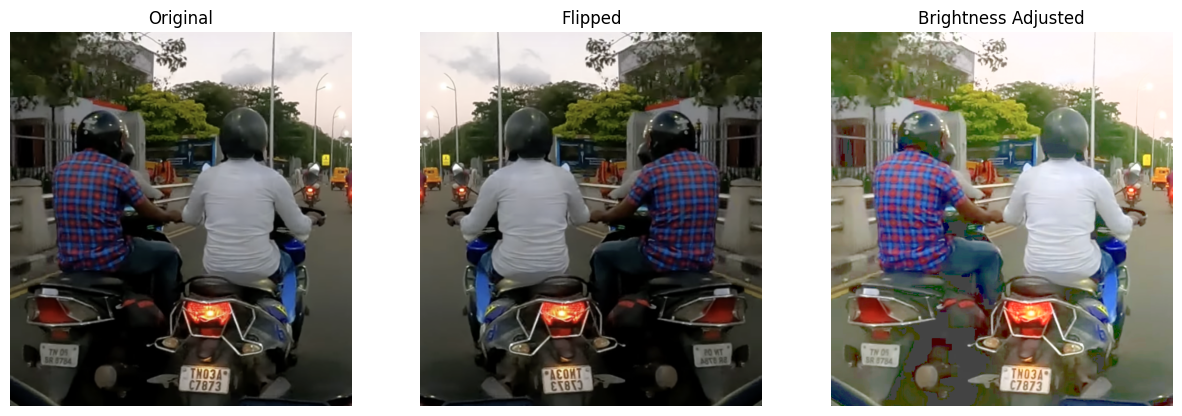

In [7]:
# Displaying the original and augmented images
original, flipped, bright_adjusted = demonstrate_augmentation('/kaggle/input/rider-with-helmet-without-helmet-number-plate/train')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(flipped, cv2.COLOR_BGR2RGB))
axes[1].set_title('Flipped')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(bright_adjusted, cv2.COLOR_BGR2RGB))
axes[2].set_title('Brightness Adjusted')
axes[2].axis('off')

plt.show()

# Navigate to the YOLOv5 directory via Command Line and Training the Model


In [8]:
# Navigate to the YOLOv5 directory
%cd /kaggle/working/yolov5

# Create a YAML file for your dataset
data_yaml_content = """
train: /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images
val: /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images

nc: 4
names: ['with helmet', 'without helmet', 'rider', 'number plate']
"""

# Write the dataset configuration to a YAML file
with open('data.yaml', 'w') as file:
    file.write(data_yaml_content)

# Command to train the YOLOv5 model
!python train.py --img 640 --batch 16 --epochs 50 \
                 --data data.yaml --cfg yolov5s.yaml \
                 --weights yolov5s.pt --name yolov5_rider_safety

/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5_rider_safety, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=Fal

# Command for testing the model on validation data


In [9]:
# Command for testing the model on new data
!python detect.py --weights /kaggle/working/yolov5/runs/train/yolov5_rider_safety/weights/best.pt \
                  --img 640 --conf 0.4 --source /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images


detect: weights=['/kaggle/working/yolov5/runs/train/yolov5_rider_safety/weights/best.pt'], source=/kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/20 /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images/new0.jpg: 640x576 2 without helmets, 1 number plate, 57.9ms
image 2/20 /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images/new113.jpg: 640x576 

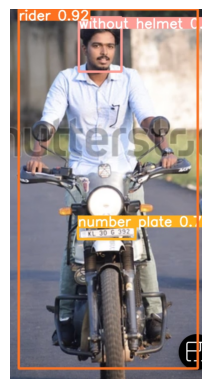

In [10]:
# Directory where the output images are saved
output_directory = '/kaggle/working/yolov5/runs/detect/exp'

# List all files in the output directory
output_files = os.listdir(output_directory)
if output_files:
    # Display the first output image as an example
    first_image_path = os.path.join(output_directory, output_files[0])
    img = mpimg.imread(first_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("No output files found.")